# Clase 22: EDOs - Métodos de múltiples pasos

Los métodos que hemos estudiado han intentado predecir $y(t_i)$ usando la predicción anterior $w_{i-1}$. Como hemos visto, el error cometido por los métodos estudiados hasta ahora va creciendo a medida que crece $t$. Debido a esto, vale la pena involucrar varias predicciones anteriores en la predicción apra $y(t_i)$.

In [1084]:
import numpy as np
import matplotlib.pyplot as plt

## Métodos de pasos múltiples

La solución exacta a la ecuación diferencial está dada formalmente por

$$
y(t_{i+1}) = y(t_i) + \int_{t_i}^{t_{i+1}}dt\,f(t, y(t))\,,
$$

no podemos resolver esa integral ya que depende de la función $y(t)$, pero podemos usar varias aproximaciones precedentes $(t_i, f(t_i, y(t_i))), (t_{i-1}, f(t_{i-1}, y(t_{i-1}))),...,(t_{i-m}, f(t_{i+1-m},y(t_{i+1-m})))$ para escribir un polinomio interpolante e integrarlo

$$
y(t_{i+1}) = y(t_i) + \int_{t_i}^{t_{i+1}}dt\,P_{m-1}(t) + \frac{1}{m!}f^{(m)}(\mu, y(\mu))\int_{t_i}^{t_{i+1}}dt\,(t - t_i)...(t - t_{i+1-m})\,,
$$

Veamos cómo funciona si usamos dos puntos anteriores. El polinomio interpolante será una interpolación lineal que escribiremos usando los polinomios de Lagrange

$$
P_2(t) = \frac{(t - t_i)}{(t_{i - 1} - t_i)}f(t_{i-1}, y(t_{i-1})) + \frac{(t - t_{i-1})}{(t_{i} - t_{i - 1})}f(t_{i}, y(t_{i})) = - s f(t_i - h, y(t_i - h)) + (s + 1)f(t_i, y(t_i))
$$

donde hemos escrito $t = t_i + sh$. Ahora tenemos

$$
y(t_{i+1}) = y(t_i) + h\int_0^1ds\,\left[-s f(t_{i-1}, y(t_{i-1})) + (s + 1)f(t_i, y(t_i))\right] + \frac{h^3}{m!}f^{(m)}(\mu, y(\mu))\int_{0}^{1}ds\,s(s+1)\,,
$$

$$
y(t_{i+1}) = y(t_i) + h\left[-\frac{1}{2} f(t_{i-1}, y(t_{i-1}))+\frac{3}{2}f(t_i, y(t_i))\right] + \frac{5h^3}{12}f^{(2)}(\mu, y(\mu))\,,
$$

Análogamente para cuatro puntos

$$
P_4(s) = \frac{(s+1)(s+2)(s+3)}{6}f(t_i,y(t_i)) - \frac{s(s+2)(s+3)}{2}f(t_{i-1},y(t_{i-1}))+ \frac{s(s+1)(s+3)}{2}f(t_{i-2},y(t_{i-2})) - \frac{s(s+1)(s+2)}{6}f(t_{i-3},y(t_{i-3}))
$$

Las integrales en $s$ son fáciles de calcular y obtenemos

$$
y(t_{i+1}) = y(t_i) + \frac{h}{24}\left[55f(t_i, y(t_i)) - 59f(t_{i-1}, y(t_{i-1})) + 37f(t_{i-2}, y(t_{i-2})) - 9f(t_{i-3}, y(t_{i-3}))\right] + \frac{251}{720}h^5f^{(4)}(\mu, y(\mu))
$$

vemos que así obtenemos un método con error de truncación local de orden $h^4$. 

A estos métodos se los llama métodos de **Adams-Bashforth**. Necesitan tres condiciones iniciales para sus primeros pasos. Estas se pueden obtener usando por ejemplo un método de Runge-Kutta.

In [1132]:
def rk4_step(f, fi, t, w, h):
    
    k1 = h*fi
    k2 = h*f(t+h/2, w+k1/2)
    k3 = h*f(t+h/2, w+k2/2)
    k4 = h*f(t + h, w + k3)
    return (k1 + 2*k2 + 2*k3 + k4)/6

def ab4(f, a, b, yo, N):
    
    h = (b-a)/N
    i = 0
    w = yo
    t = a
    
    ws = np.zeros(N+1)
    ts = np.zeros(N+1)
    fi = 0
    fim1 = 0
    fim2 = 0
    fim3 = 0
    
    for i in range(N):
        ts[i] = t
        ws[i] = w
        fim3 = fim2
        fim2 = fim1
        fim1 = fi
        fi = f(t,w)
        if i < 3:
            w += rk4_step(f, fi, t, w, h)
        else:
            w += h*(55*fi - 59*fim1 +37*fim2 - 9*fim3)/24
        t += h
        
    ws[N] = w
    ts[N] = t
    
    return ts, ws

Comparemos con el método de Runge-Kutta

In [1133]:
def rk4(f, a, b, yo, N):
    
    h = (b-a)/N
    t = a
    w = yo
    ts = np.zeros(N+1)
    sol = np.zeros(N+1)
    
    for i in range(N):
        ts[i] = t
        sol[i] = w
        k1 = h*f(t, w)
        k2 = h*f(t+h/2, w+k1/2)
        k3 = h*f(t+h/2, w+k2/2)
        k4 = h*f(t + h, w + k3)
        w = w + (k1 + 2*k2 + 2*k3 + k4)/6
        t = t + h
        
    ts[N] = t
    sol[N] = w
    
    return ts, sol

In [1134]:
def f(t, y):
    return y - t**2 + 1

a = 0
b = 2
yo = 0.5

def exacta(t):
    return (t + 1)**2 - 0.5*np.exp(t)

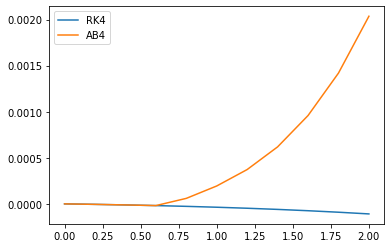

In [1135]:
sol_rk4 = rk4(f, a, b, yo, 10)
sol_ab4 = ab4(f, a, b, yo, 10)

plt.plot(sol_rk4[0], sol_rk4[1] - exacta(sol_rk4[0]), label='RK4')
plt.plot(sol_ab4[0], sol_ab4[1] - exacta(sol_ab4[0]), label='AB4')
plt.legend()

El error es mayor, y parte de la razón es que estamos usando un polinomio interpolante para extrapolar. Podemos mejorar la aproximación si usamos el punto $(t_{i+1}, f(y(t_{i+1})))$ para el polinomio interpolante:

$$
P_4(s) = \frac{s(s+1)(s+2)}{6}f(t_{i+1},y(t_{i+1})) - \frac{(s-1)(s+1)(s+2)}{2}f(t_{i},y(t_{i}))+ \frac{s(s-1)(s+2)}{2}f(t_{i-1},y(t_{i-1})) - \frac{s(s-1)(s+1)}{6}f(t_{i-3},y(t_{i-3}))
$$

Ahora las integrales dan

$$
y(t_{i+1}) = y(t_i) + \frac{h}{24}\left[9f(t_{i+1}, y(t_{i+1})) + 19f(t_{i}, y(t_{i})) - 5f(t_{i-1}, y(t_{i-1})) + f(t_{i-2}, y(t_{i-2}))\right] - \frac{19}{720}h^5f^{(4)}(\mu, y(\mu))
$$

Tenemos un método de orden $h^4$ de nuevo, pero es difícil ver cómo usarlo ya que necesitamos $y(t_{i+1})$, pero es lo que queremos calcular. Este método se llama de **Adams-Moulton**.

Lo que podemos hacer es usar el Adams-Bashforth para predecir $y(t_{i+1})$ y usar esa aproximación dentro de la fórmula de Adams-Moulton para corregir la aproximación. A esto se lo llama un método **predictor-corrector**.

In [1089]:
def rk4_step(f, fi, t, w, h):
    
    k1 = h*fi
    k2 = h*f(t+h/2, w+k1/2)
    k3 = h*f(t+h/2, w+k2/2)
    k4 = h*f(t + h, w + k3)
    return (k1 + 2*k2 + 2*k3 + k4)/6

def apc4(f, a, b, yo, N):
    
    h = (b-a)/N
    i = 0
    w = yo
    t = a
    
    ws = np.zeros(N+1)
    ts = np.zeros(N+1)
    fi = 0
    fim1 = 0
    fim2 = 0
    fim3 = 0
    
    for i in range(N):
        ts[i] = t
        ws[i] = w
        fim3 = fim2
        fim2 = fim1
        fim1 = fi
        fi = f(t,w)
        if i < 3:
            w += rk4_step(f, fi, t, w, h)
        else:
            # Predictor Adams-Bashforth de 4 pasos
            w = ws[i] + h*(55*fi - 59*fim1 +37*fim2 - 9*fim3)/24
            # Corrector Adams-Moulton de 3 pasos
            w = ws[i] + h*(9*f(t + h, w) + 19*fi - 5*fim1 + fim2)/24
        t += h
        
    ws[N] = w
    ts[N] = t
    
    return ts, ws

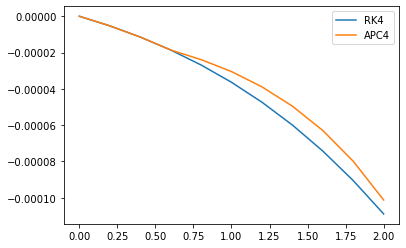

In [1090]:
sol_rk4 = rk4(f, a, b, yo, 10)
sol_ab4 = ab4(f, a, b, yo, 10)
sol_apc = apc4(f, a, b, yo, 10)

plt.plot(sol_rk4[0], sol_rk4[1] - exacta(sol_rk4[0]), label='RK4')
#plt.plot(sol_ab4[0], sol_ab4[1] - exacta(sol_ab4[0]), label='AB4')
plt.plot(sol_apc[0], sol_apc[1] - exacta(sol_apc[0]), label='APC4')
plt.legend()

Vemos que el error es ligeramente menor (en valor absoluto). En realidad esto depende del problema particular en consideración, y de hecho puede que en este mismo problema el error de APC tenga un crecimiento más rápido que RK para valores grandes de $t$. Una ventaja del método de Adams es que requiere sólo dos nuevas evaluaciones a cada paso, lo que lo hace más rápido que RK para una precisión similar.

## Métodos de múltiples pasos con control de error

En el método de Runge-Kutta-Fehlberg usamos dos aproximaciones para estimar el error cometido y ajustar el paso para obtener un error local menor que la tolerancia requerida. En el método de Adams predictor corrector tenemos ya las dos aproximaciones y las podemos usar para estimar el error. Veamos cómo:

Los errores de truncación locales de Adams-Bashforth y Adams-Moulton son respectivamente

$$
\hat{\tau}_{i+1}(h) \approx \frac{y(t_{i+1}) - \hat{w}_{i+1}}{h} = \frac{251}{720}y^{(5)}(\hat{\mu})h^4
$$

$$
\tau_{i+1}(h) \approx \frac{y(t_{i+1}) - w_{i+1}}{h} = -\frac{19}{720}y^{(5)}(\mu)h^4
$$

donde hemos asumido que $y(t_i),...,y(t_{i-3})$ están bien aproximadas por $w_i,...,w_{i-3}$. Si adicionalmente asumimos que $y^{(5)}(\mu) \approx y^{(5)}(\hat{\mu})$ tenemos

$$
\frac{w_{i+1} - \hat{w}_{i+1}}{h} \approx \frac{3}{8}h^4y^{(5)}(\mu)
$$

reemplazando esto en el error de Adams-Moulton obtenemos

$$
|\tau_{i+1}(h)| = \frac{19}{720}.\frac{8}{3h^5}|w_{i+1} - \hat{w}_{i+1}| = \frac{19}{270h}|w_{i+1} - \hat{w}_{i+1}|
$$

Ahora bien, queremos reducir el paso de un factor $\delta$ tal que el error esté por debajo de una cierta tolerancia $\epsilon$. Usando las expresiones del error tenemos que

$$
|\tau_{i+1}(\delta h)| = \frac{19}{720}y^{(5)}(\mu)\delta^4h^4 = \delta^4|\tau_{i+1}(h)|
$$

entonces

$$
\epsilon > |\tau_{i+1}(\delta h)| = \delta^4|\tau_{i+1}(h)| = \frac{19\delta^4}{270h}|w_{i+1} - \hat{w}_{i+1}|
$$

despejando

$$
\delta < \left(\frac{270}{19}\frac{h\epsilon}{|w_{i+1} - \hat{w}_{i+1}|}\right)^{1/4}
$$

In [1091]:
def rk4_step(f, fi, t, w, h):
    
    k1 = h*fi
    k2 = h*f(t+h/2, w+k1/2)
    k3 = h*f(t+h/2, w+k2/2)
    k4 = h*f(t + h, w + k3)
    return (k1 + 2*k2 + 2*k3 + k4)/6

class MinStep(Exception):
    pass

def apce(f, a, b, yo, tol, hmin, hmax):
    
    h = hmax
    flag = 1 # Indica si terminamos
    last = 0 # Indica si es el último paso
    
    ts = [a]
    ws = [yo]
    hs = [h]
    rs = [-1]
    
    fi = f(ts[0], ws[0])
    fim1 = 0
    fim2 = 0
    fim3 = 0
    
    # Puntos iniciales obtenidos de Runge-Kutta
    for i in range(3):
        ws.append(ws[i] + rk4_step(f, fi, ts[i], ws[i], h))
        ts.append(ts[i] + h)
        hs.append(h)
        rs.append(-1)
        fim3 = fim2
        fim2 = fim1
        fim1 = fi
        fi = f(ts[i+1], ws[i+1])
    nflag = 1 # Indica si los últimos puntos fueron obtenidos con RK
    i = 4
    t = ts[3] + h
    
    while flag:
        
        # Predictor Adams-Bashforth de 4 pasos
        wp = ws[i-1] + h*(55*fi - 59*fim1 +37*fim2 - 9*fim3)/24
        # Corrector Adams-Moulton de 3 pasos
        wc = ws[i-1] + h*(9*f(t, wp) + 19*fi - 5*fim1 + fim2)/24
        
        # Estima del error dada por la diferencia entre dos Adams
        sigma = 19*abs(wc - wp)/(270*h)
        
        # Si el error es menor que la tolerancia, se acepta el paso
        if sigma <= tol:
            ws.append(wc)
            ts.append(t)
            hs.append(h)
            rs.append(sigma)
            fim3 = fim2
            fim2 = fim1
            fim1 = fi
            fi = f(ts[i], ws[i])
            
            # Si es el último paso, terminamos
            if last:
                flag = 0
            else:
                i += 1
                nflag = 0
                
                # Incrementamos h si es más preciso de lo requerido
                # o lo reducimos para incluir b
                if sigma <= 0.1*tol or ts[i-1] + h > b:
                    delta = (tol/(2*sigma))**(1/4)
                    if delta > 4: # Evitamos que crezca demasiado
                        h = 4*h 
                    else:
                        h = delta*h
                    if h > hmax:
                        h = hmax
                    if ts[i-1] + 4*h > b:
                        h = (b - ts[i-1])/4
                        last = 1
                    # Como h cambió, necesitamos volver a calcular los
                    # puntos iniciales para los Adams
                    for j in range(3):
                        ws.append(ws[i+j-1] + rk4_step(f, fi, ts[i+j-1], ws[i+j-1], h))
                        ts.append(ts[i+j-1] + h)
                        hs.append(h)
                        rs.append(-1)
                        fim3 = fim2
                        fim2 = fim1
                        fim1 = fi
                        fi = f(ts[i+j],ws[i+j])  
                    i += 3
                    nflag = 1
        else: # sigma > tol
            # disminuimos h
            delta = (tol/(2*sigma))**(1/4)
            if delta < 0.1: # evitamos que disminuya demasiado
                h = 0.1*h
            else:
                h = delta*h
                
            if h < hmin:
                raise MinStep('Tamaño de paso mínimo excedido', ts, ws, hs, rs)
            else:
                if nflag: # los últimos pasos vienen de RK
                    i -= 3 # se rechazan los pasos anteriores del RK
                    fi = fim3
                    for j in range(3):
                        ws[i+j] = ws[i+j-1] + rk4_step(f, fi, ts[i+j-1], ws[i+j-1], h)
                        ts[i+j] = ts[i+j-1] + h
                        hs[i+j] = h
                        rs[i+j] = -1
                        fim3 = fim2
                        fim2 = fim1
                        fim1 = fi
                        fi = f(ts[i+j],ws[i+j])
                    i += 3
                    nflag = 1
                else:
                    for j in range(3):
                        ws.append(ws[i+j-1] + rk4_step(f, fi, ts[i+j-1], ws[i+j-1], h))
                        ts.append(ts[i+j-1] + h)
                        hs.append(h)
                        rs.append(-1)
                        fim3 = fim2
                        fim2 = fim1
                        fim1 = fi
                        fi = f(ts[i+j],ws[i+j])
                    i += 3
                    nflag = 1
        
        t = ts[i-1] + h
        # fin del while
            
    return np.array(ts), np.array(ws), np.array(hs), np.array(rs)

In [1092]:
def rkf(f, a, b, yo, tol, hmin, hmax):
    
    t = a
    w = yo
    h = hmax
    flag = 1
    
    ts = [t]
    sol = [w]
    hs = []
    rs = []
    
    while flag:
        
        # Evaluaciones de la función 
        k1 = h*f(t, w)
        k2 = h*f(t + h/4, w + k1/4)
        k3 = h*f(t + 3*h/8, w + 3*k1/32 + 9*k2/32)
        k4 = h*f(t + 12*h/13, w + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h*f(t + h, w + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        k6 = h*f(t + h/2, w - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        
        # Estima del error dada por la diferencia entre dos RKs
        R = abs(k1/360 - 128*k3/4275 - 2197*k4/75240 + k5/50 + 2*k6/55)
        
        # Si el error es menor que la tolerancia, se acepta el paso
        if R <= tol:
            t += h
            w = w + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
            ts.append(t)
            sol.append(w)
            hs.append(h)
            rs.append(R)
            
        # el 0.84 es un factor para hacer la estima más conservadora 
        # corresponde a 1/2**(1/4)
        q = 0.84*(tol/R)**(1/4)
        
        # ACTUALIZACIÓN DE h
        # Se establece un q mínimo para no quedarse atrapado en alguna región.
        # Esto se puede cambiar.
        if q <= 0.1:
            h = 0.1*h
        # Se establece también un q máximo para no peder detalles de la función
        elif q >= 4:
            h = 4*h
        else:
            h = q*h
        if h > hmax:
            h = hmax
        
        # Si nos pasamos de b, terminamos
        if t >= b:
            flag = 0
        # El último paso debe llegar a b
        elif t + h > b:
            h = b - t
        elif h < hmin:
            raise MinStep('Se excedió el paso mínimo.')
            
    return np.array(ts), np.array(sol), np.array(hs), np.array(rs)

In [1093]:
apce(f, a, b, yo, 1e-5, 0.01, 0.2)

(array([0.        , 0.12841311, 0.25682622, 0.38523933, 0.51365244,
        0.64206555, 0.77047866, 0.89889178, 1.02730489, 1.155718  ,
        1.28413111, 1.38980571, 1.49548031, 1.6011549 , 1.7068295 ,
        1.8125041 , 1.9181787 , 1.93863403, 1.95908935, 1.97954468,
        2.        ]),
 array([0.5       , 0.70480426, 0.93320071, 1.18390304, 1.4554489 ,
        1.74617506, 2.05419064, 2.3773457 , 2.7131957 , 3.05896114,
        3.41148167, 3.70412624, 3.99667129, 4.28661635, 4.57118181,
        4.84727903, 5.11147478, 5.16092479, 5.20975773, 5.25794355,
        5.30545159]),
 array([0.2       , 0.12841311, 0.12841311, 0.12841311, 0.12841311,
        0.12841311, 0.12841311, 0.12841311, 0.12841311, 0.12841311,
        0.12841311, 0.1056746 , 0.1056746 , 0.1056746 , 0.1056746 ,
        0.1056746 , 0.1056746 , 0.02045532, 0.02045532, 0.02045532,
        0.02045532]),
 array([-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         4.43185053e-06,  5.05751905e-06, 

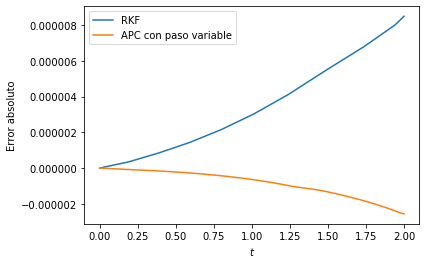

In [1094]:
ts_rkf, sol_rkf, hs_rkf, rs_rkf = rkf(f, 0, 2, 0.5, 1e-6, 0.01, 0.25)
ts_apce, sol_apce, hs_apce, rs_apce = apce(f, 0, 2, 0.5, 1e-6, 0.01, 0.25)
exacta_rkf = (ts_rkf + 1)**2 - 0.5*np.exp(ts_rkf)
exacta_apce = (ts_apce + 1)**2 - 0.5*np.exp(ts_apce)
plt.plot(ts_rkf, sol_rkf - exacta_rkf, label='RKF')
plt.plot(ts_apce, sol_apce - exacta_apce, label='APC con paso variable')
plt.xlabel('$t$')
plt.ylabel('Error absoluto')
plt.legend()

La desventaja de este método es que al modificar $h$ puede ser necesario recalcular varios puntos.

## Tareas

## Tarea 11.6

Modifique los códigos de Runge-Kutta-Fehlberg y Adams con control de error para que impriman el número de pasos requeridos. Luego resuelva el siguiente problema de condición incial con ambos métodos y compare para diferentes tolerancias:

$$
y'(t) = (1/t)(y^2 + y)\,,\quad 1 \leq t \leq 3\,,\quad y(1) = -2\,.
$$

## Tarea 11.7

Escriba un código que implemente el método de Adams-Bashforth de dos pasos. Úselo para resolver el siguiente problema

$$
y'(t) = 1 + \frac{y}{t} + \left(\frac{y}{t}\right)^2\,,\quad 1 \leq t \leq 1.5\,,\quad y(1) = 0\,.
$$

Para ser consistente con el orden, los primeros pasos deberían ser dados por un Runge-Kutta de orden 2.

## Tarea 11.8

Use el método de Adams-Moulton de tres pasos descrito en clase para resolver el siguiente problema de valor inicial:

$$
y'(t) = te^{3t} - 2y\,,\quad 0 \leq t \leq 1\,, \quad y(0) = 0\,.
$$

Recuerde que este método usa $w_{i+1}$ para calcular $w_{i+1}$ tal que es necesario resolver algebráicamente la ecuación resultante y así obtener una expresión explícita para $w_{i + 1}$ que se pueda usar en el código.

## Tarea 11.9

Ejercicio 5.6.15, libro de Burden

El algoritmo del predictor-corrector intenta predecir el valor de $y_{i+1}$ a partir de un Adams-Bashforth y luego usa ese resultado dentro de un Adams-Moulton para aproximarse más al verdadero valor. Esto se podría iterar varias veces, es decir usar esa predicción corregida dentro del mismo Adams-Moulton para corregir ulteriormente el valor. 

* Modifique el algoritmo de predictor-corrector para que el corrector se pueda iterar $p$ veces.

* Resuelva el siguiente problema de valor inicial para $p = 2, 3, 4$. ¿Cuál da un mejor resultado?

$$
y'(t) = \frac{y}{t} - \left(\frac{y}{t}\right)^2\,,\quad 1\leq t\leq 2, y(1) = 1,
$$

con $h = 0.1$, siendo la solución analítica $y(t) = t/(1+ \ln(t))$.

## Tarea 11.10

Ejercicio 5.7.12, libro de Burden

Sea $P(t)$ la cantidad de individuos en una población al tiempo $t$, medido en años. Si el la tasa de nacimientos promedio $b$ es constante y la tasa de muerte promedio $d$ es proporcional al tamaño de la población (debido al hacinamiento), entonces la razón de crecimiento de la población está dada por la ecuación logística

$$
\frac{d P(t)}{dt} = bP(t) - k[P(t)]^2
$$

donde $d = kP(t)$. Suponga que $P(0) = 50976$, $b = 2.9\times 10^{-2}$ y $k = 1.4\times 10^{-7}$. Encuentre la población luego de $5$ años.